In [1]:
# %init
import glob, sys, os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from yahist import Hist1D, Hist2D
import glob
np.set_printoptions(linewidth=150)

from myhelpers.dataframes import fix_types
from myhelpers.personal import sqlite_magic

from PIL import Image
import cv2

In [2]:
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 933120000

In [3]:
# https://webbtelescope.org/contents/media/images/2023/114/01GYZ71RJZ8YDS71CKF6G2F18R
full_img = Image.open("STScI-01GYZA4EB3R5E1EZ4NJQPKHVRA.png")

In [4]:
arr = np.array(full_img)

In [5]:
arr.nbytes, arr.shape

(2134440000, (15400, 46200, 3))

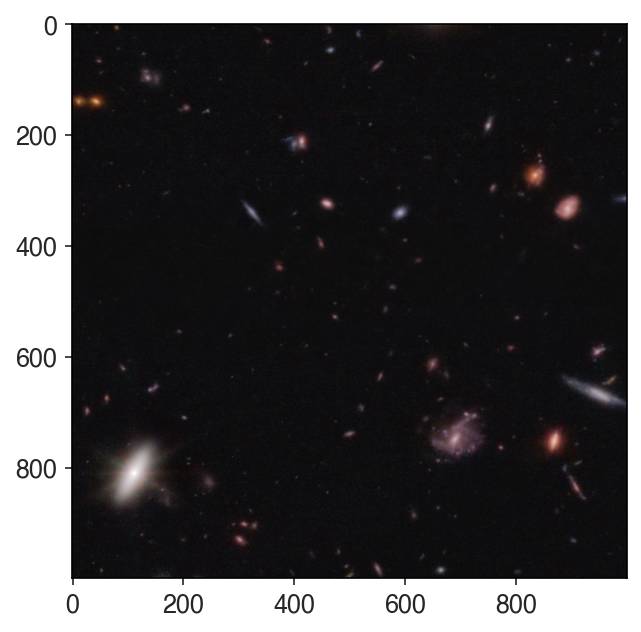

In [6]:
plt.imshow(arr[7000:8000, 23000:24000])

In [7]:
# Create an OpenCV image from the NumPy array
img = arr[7000:7500, 23000:23500]
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

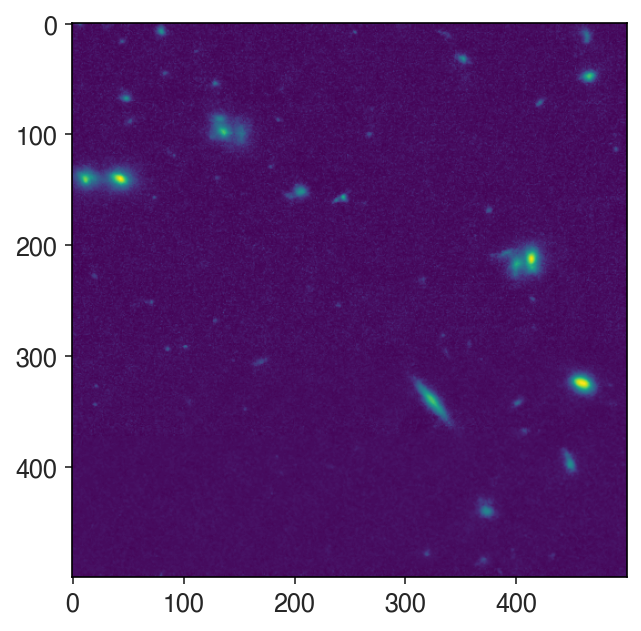

In [8]:
plt.imshow(gray)

# th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
# ret,th1 = cv2.threshold(img,80,255,cv2.THRESH_BINARY)
# plt.imshow(th1)

In [9]:
def scale_by(img, fraction=1.0):
    width = int(img.shape[1] * fraction)
    height = int(img.shape[0] * fraction)
    dim = (width, height)
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

def rotate_image(image, angle=0):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

# def letter_to_image(letter, scale=1.0, rotation=0.0):
def letter_to_image(letter, rotation=0.0):
# letter = "B"

    from matplotlib.textpath import TextPath
    from matplotlib.patches import PathPatch
    import matplotlib
    fig, ax = plt.subplots(figsize=(2,2))
    tp = TextPath((0,0), letter, size=0.15)
    pp = PathPatch(tp, color="black")
    t = matplotlib.transforms.Affine2D().rotate_deg_around(0.05,0.05,-rotation) + ax.transData
    pp.set_transform(t)

    plt.gca().add_patch(pp)
    plt.axis("off")
    ax.set_xlim(-0.04,0.15)
    ax.set_ylim(-0.04,0.15)

    # If we haven't already shown or saved the plot, then we need to
    # draw the figure first...
    fig.canvas.draw()

    # Now we can save it to a numpy array.
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close()
    
#     data = scale_by(data, fraction=scale)
#     data = rotate_image(data, angle=rotation)
    return data

#     data.min(), data.max()

In [10]:
# import matplotlib
# help(matplotlib.transforms.Affine2D)

In [11]:
# help(TextPath)
# help(PathPatch)

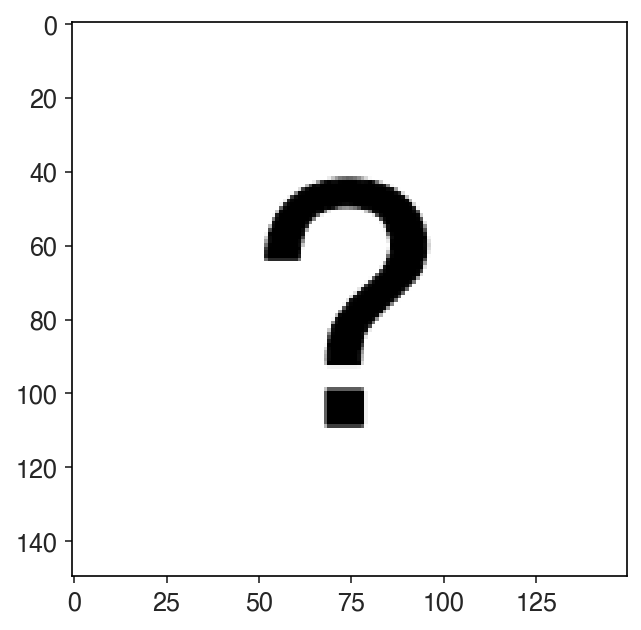

In [12]:
plt.imshow(letter_to_image("?", rotation=0))

In [13]:
# template = letter_to_image("C")
# template = scale_by(template, 0.5)
# template = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
# template = 255-template # hot letter, dark background
# plt.imshow(template)

In [14]:
def filter_close_points(points: "list[tuple[int,int]]", scores: "list[float]", min_dist=5) -> "tuple[list[tuple[int,int]], list[float]]":
    output_points = []
    output_scores = []
    prev_point = None
    for point, score in zip(points, scores):
        if prev_point is not None:
            if (point[0] - prev_point[0])**2 + (point[1] - prev_point[1])**2 < min_dist**2:
                continue
        output_points.append(point)
        output_scores.append(score)
        prev_point = point
    return output_points, output_scores

(846, 278) 0.5352002
(819, 696) 0.5360905


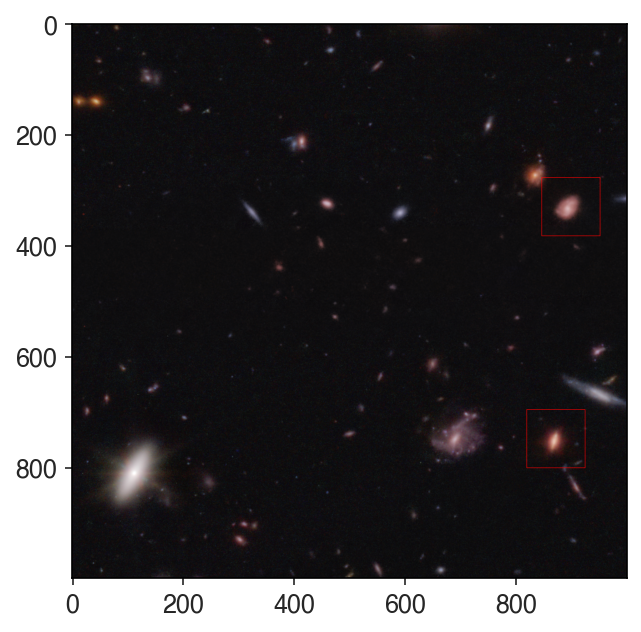

In [15]:
import cv2 as cv
match_data = []

# template = letter_to_image("A")
char = "8"
scale = 0.7
rotation = -45
template = letter_to_image(char, rotation=rotation)
template = scale_by(template, scale)
template = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
template = 255-template # hot letter, dark background

# patch = np.array(arr[7000:7500, 23000:23500])
# patch = np.array(arr[7000:8000, 23000:24000])
patch_x = 23000
patch_y = 7000
patch_dx = patch_dy = 1000
patch = np.array(arr[patch_y:(patch_y+patch_dy), patch_x:(patch_x+patch_dx)])
gray = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)

res = cv2.matchTemplate(gray, template, cv.TM_CCOEFF_NORMED)

top_k = 10
top_q = (1 - top_k/np.prod(res.shape))
thresh = np.quantile(np.array(res.flat), top_q)

loc = np.where(res >= thresh)
scores = res[loc]
w, h = template.shape[::-1]
points = list(zip(*loc[::-1]))
points, scores = filter_close_points(points, scores=scores, min_dist=10)
for point, score in zip(points, scores):
    print(point, score)
    match_data.append(
        dict(
            patch_x=patch_x,
            patch_y=patch_y,
            patch_dx=patch_dx,
            patch_dy=patch_dy,
            char=char,
            scale=scale,
            rotation=rotation,
            match_slice=(slice(patch_y + point[1],patch_y + point[1]+h), slice(patch_x + point[0],patch_x + point[0]+w)),
            score=score,
            threshold=thresh,
            top_k=top_k,
        )
    )
    cv.rectangle(patch, point, (point[0] + w, point[1] + h), (255,0,0), 1)
    
plt.imshow(patch)

In [16]:
match_data

[{'patch_x': 23000,
  'patch_y': 7000,
  'patch_dx': 1000,
  'patch_dy': 1000,
  'char': '8',
  'scale': 0.7,
  'rotation': -45,
  'match_slice': (slice(7278, 7383, None), slice(23846, 23951, None)),
  'score': 0.5352002,
  'threshold': 0.535200178822916,
  'top_k': 10},
 {'patch_x': 23000,
  'patch_y': 7000,
  'patch_dx': 1000,
  'patch_dy': 1000,
  'char': '8',
  'scale': 0.7,
  'rotation': -45,
  'match_slice': (slice(7696, 7801, None), slice(23819, 23924, None)),
  'score': 0.5360905,
  'threshold': 0.535200178822916,
  'top_k': 10}]

In [17]:
match_data = []

patch_dx = patch_dy = 1000
for patch_y in tqdm(range(0, arr.shape[0], patch_dy)):
    for patch_x in tqdm(range(0, arr.shape[1], patch_dx)):
        # patch_x = 23000
        # patch_y = 7000
#         patch = np.array(arr[patch_y:(patch_y+patch_dy), patch_x:(patch_x+patch_dx)])
        patch = arr[patch_y:(patch_y+patch_dy), patch_x:(patch_x+patch_dx)]
        if patch.sum() == 0: 
            continue
        gray = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)

        # template = letter_to_image("A")
#         char = "?"
#         for char in ["?"]:
#         for char in ["N","I","C","K","A","M","X","O","H","8","%","+","!","?"]:
        for char in ["N","I","C","K","A","M","X","O","H","8","%","+","!","?","=","~",":"]:
#         for char in ["=","~",":"]:
#             for rotation in [0,45,90,135,180,225,270,315]:
            for rotation in [0,45,90,135]:
                template_unscaled = letter_to_image(char, rotation=rotation)
#                 for scale in [0.3,0.4,0.5,0.6]:
#                 for scale in [0.8]:
#                 for scale in [1.2]:
#                 for scale in [0.3,0.4,0.6,0.8,1.2]:
                for scale in [1.4,1.7]:
#                     print(scale, rotation)
                    template = scale_by(template_unscaled, fraction=scale)
                    template = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
                    template = 255-template # hot letter, dark background

                    res = cv2.matchTemplate(gray, template, cv2.TM_CCOEFF_NORMED)

                    top_k = 10
                    top_q = (1 - top_k/np.prod(res.shape))
                    thresh = np.quantile(np.array(res.flat), top_q)

                    loc = np.where((res >= thresh) & (res >= 0.1))
                    scores = res[loc]
                    w, h = template.shape[::-1]
                    points = list(zip(*loc[::-1]))
                    points, scores = filter_close_points(points, scores=scores, min_dist=10)
#                     print(len(points))
                    for point, score in zip(points, scores):
                        match_data.append(
                            dict(
                                patch_x=patch_x,
                                patch_y=patch_y,
                                patch_dx=patch_dx,
                                patch_dy=patch_dy,
                                char=char,
                                scale=scale,
                                rotation=rotation,
                                match_slice=(slice(patch_y + point[1],patch_y + point[1]+h), slice(patch_x + point[0],patch_x + point[0]+w)),
                                score=score,
                                threshold=thresh,
                                top_k=top_k,
                            )
                        )

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

In [19]:
df_match = pd.DataFrame(match_data)
# df_match.to_pickle("df_match3.pickle")
# df_match.to_pickle("df_match4.pickle")
# df_match.to_pickle("df_match5.pickle")

In [20]:
df_match = pd.concat([
    pd.read_pickle("df_match.pickle"),
    pd.read_pickle("df_match2.pickle"),
    pd.read_pickle("df_match3.pickle"),
    pd.read_pickle("df_match4.pickle"),
    pd.read_pickle("df_match5.pickle"),
]).reset_index(drop=True)

In [21]:
def f(x):
    return (
        int(0.5*(x[0].start + x[0].stop)//200)*200,
        int(0.5*(x[1].start + x[1].stop)//200)*200,
    )
df_match["match_bucket"] = df_match["match_slice"].apply(f)
df_match["bucket_rank"] = df_match.groupby(["match_bucket","scale","char"])["score"].rank(ascending=False)

# de-dupe by taking highest score match per (match_bucket,scale,char)
df_match = df_match.query("bucket_rank==1").reset_index(drop=True)

In [23]:
def rotate_image(image, angle=0):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
    return result

def scale_to_150(img):
    return cv2.resize(img, (150,150), interpolation=cv2.INTER_AREA)
imgs = []
for i, row in df_match.query("scale>=0.3 and char=='?'").sort_values("threshold",ascending=False).head(25).iterrows():
#     print(row.to_dict())
    img = arr[row["match_slice"]]
    img = rotate_image(img, angle=+row["rotation"])
    img = scale_to_150(img)
    imgs.append(img)
#     fig, ax = plt.subplots()
#     ax.imshow(img)

In [24]:
def clean(ax):
    ax.set_frame_on(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
# def make_mnist_plots(preds,rows=None,cols=None,fname=None,show=False):
#     n_examples = preds.shape[0]
#     imgs = preds.reshape(n_examples, 28, 28)
#     rows = rows or int(n_examples**0.5)
#     cols = cols or int(n_examples**0.5)
#     fig, axs = plt.subplots(rows,cols,figsize=(cols,rows))
#     for img,ax in zip(imgs,axs.reshape(-1)):
#         ax.imshow(img,cmap="gray_r")
        
#     map(clean,fig.axes)
#     # fig.set_tight_layout(True)
#     fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.05, hspace=0.05)
#     if fname: fig.savefig(fname)
#     if show: display(Image(fname))

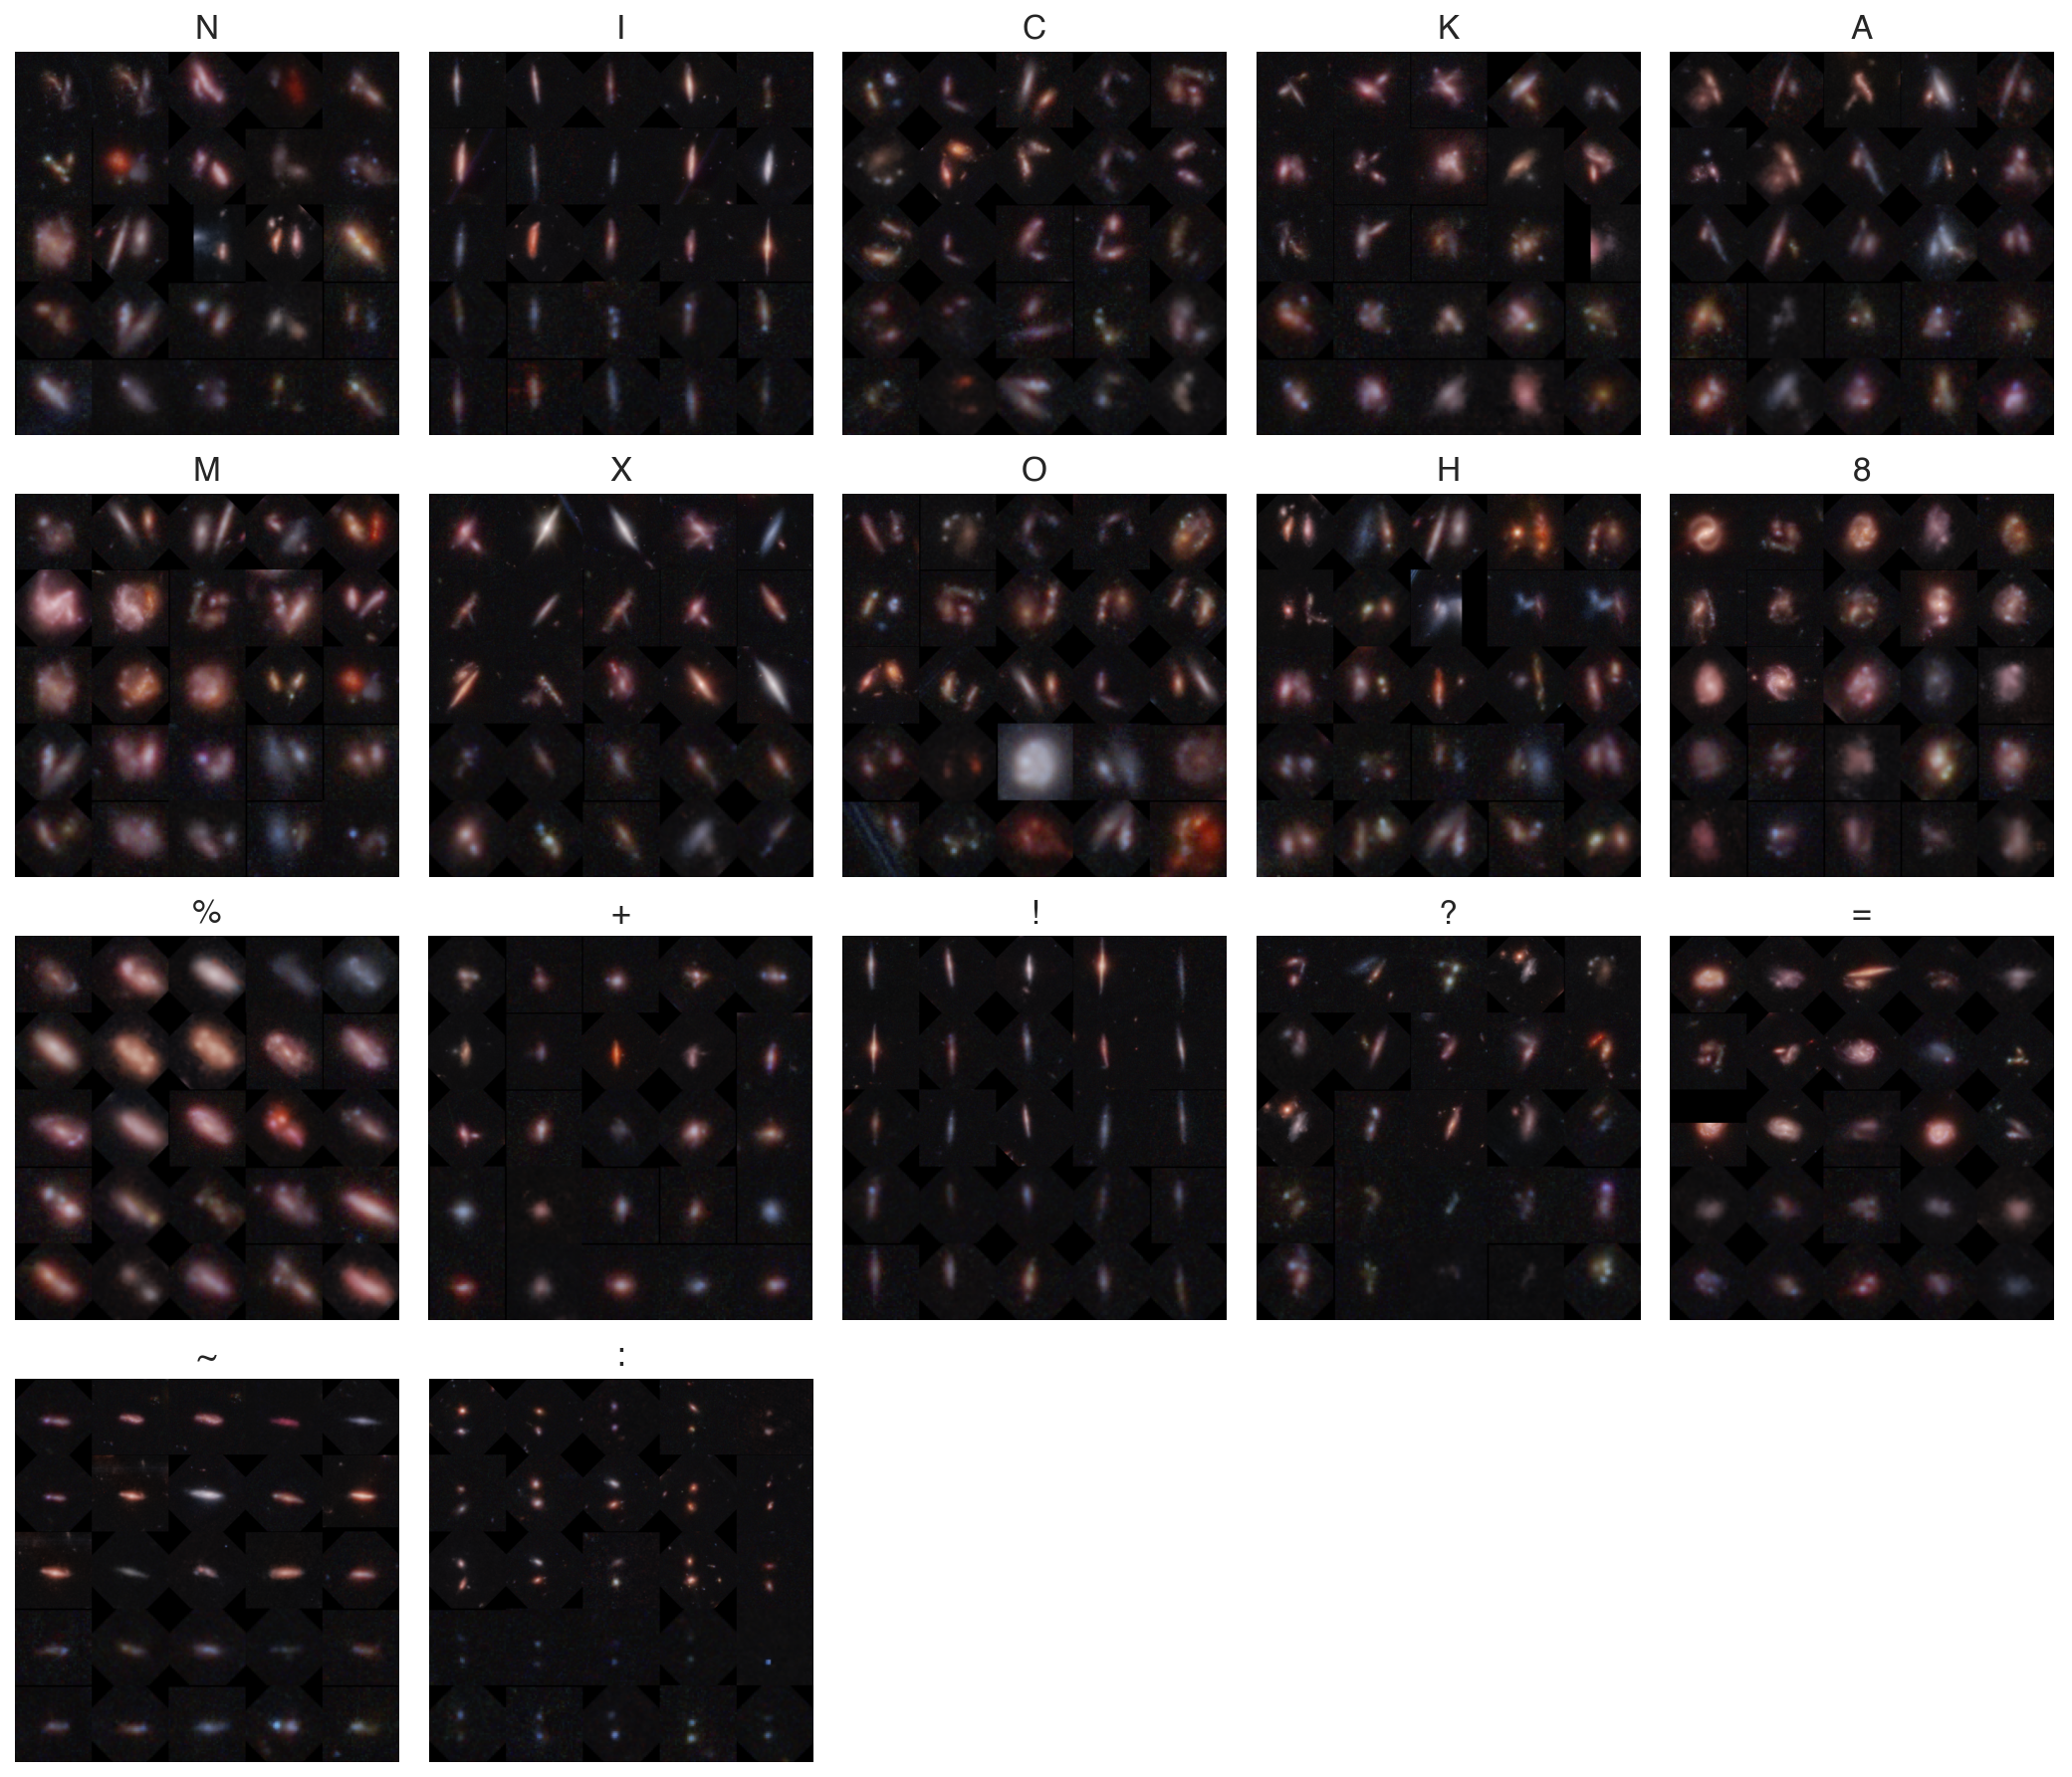

In [31]:
# chars = ["N","I","C","K","?"]
chars = ["N","I","C","K","A","M","X","O","H","8","%","+","!","?","=","~",":"]
fig, axs = plt.subplots(4,5, figsize=(14,12))
for ax, char in zip(axs.flat, chars):
    imgs = []
#     for i, row in df_match.query(f"scale<=0.3 and char=='{char}'").sort_values("score",ascending=False).head(25).iterrows():
#         img = arr[row["match_slice"]]
#         img = rotate_image(img, angle=row["rotation"])
#         img = scale_to_150(img)
#         imgs.append(img)
    for i, row in df_match.query(f"scale>0.3 and char=='{char}'").sort_values("score",ascending=False).head(15).iterrows():
        img = arr[row["match_slice"]]
        img = rotate_image(img, angle=row["rotation"])
        img = scale_to_150(img)
        imgs.append(img)
    for i, row in df_match.query(f"scale<=0.3 and char=='{char}'").sort_values("score",ascending=False).head(10).iterrows():
        img = arr[row["match_slice"]]
        img = rotate_image(img, angle=row["rotation"])
        img = scale_to_150(img)
        imgs.append(img)

    tiled_img = np.vstack([np.hstack(x) for x in np.split(np.array(imgs),5)])
    ax.set_title(char, fontsize=16, )
    ax.imshow(tiled_img)
for ax in axs.flat:
    clean(ax)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0.11)

fig.set_tight_layout(True)
fig.savefig("cosmic_characters.png")

In [136]:
# np.hstack(imgs[:5]).shape
